In [2]:
!pip install geomloss

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━

In [3]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from time import sleep
from geomloss import SamplesLoss

In [4]:
# Parameters
dataset_name = 'mnist'  # ['mnist', 'fashion']
img_size = 32
n_channels = 1
img_coords = 2
lr = 1e-4
batch_size = 32
nz = 1  # Latent dimension
ngf = 32
condition_dim = 10  # Number of classes in MNIST
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
# Helper function
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# Load dataset
if dataset_name == 'mnist':
    dataset = torchvision.datasets.MNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))
elif dataset_name == 'fashion':
    dataset = torchvision.datasets.FashionMNIST('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.Resize(32), torchvision.transforms.ToTensor()
    ]))

train_loader = torch.utils.data.DataLoader(dataset, sampler=None, shuffle=True, batch_size=batch_size, drop_last=True)
train_iterator = iter(cycle(train_loader))


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 12922643.64it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 524921.86it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3692741.27it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8014526.20it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [6]:
# Conditional Decoder
class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim, condition_dim, args):
        super(ConditionalDecoder, self).__init__()
        self.latent_size = args['width'] // 16
        self.latent_dim = latent_dim
        self.fc = nn.LazyLinear((self.latent_size**2) * args['channels'])

        self.net = nn.Sequential(
            nn.LazyConvTranspose2d(512, 4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConvTranspose2d(256, 4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConvTranspose2d(128, 4, stride=2, padding=1),
            nn.LazyBatchNorm2d(),
            nn.ReLU(),
            nn.LazyConvTranspose2d(args['channels'], 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z, c):
        # Reshape c to match z
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, z.size(2), z.size(3))  # Expand c to match z
        x = torch.cat([z, c], dim=1)
        x = self.fc(x.view(x.size(0), -1))
        f = x.size(1) // n_channels
        s = int(np.sqrt(f))
        x = x.view(z.size(0), n_channels, s, s)
        x = self.net(x)
        return x


In [7]:
# GeomLoss function
ot_loss_fn = SamplesLoss("sinkhorn", p=2, blur=0.001)

def ot_loss(x, y):
    return ot_loss_fn(x.view(x.size(0), -1), y.view(y.size(0), -1))

# Initialize model and optimizer
args = {
    'width': img_size,
    'height': img_size,
    'channels': n_channels,
    'batch_size': batch_size,
    'latent_dim': nz
}
decoder = ConditionalDecoder(nz, condition_dim, args).to(device)
opt = torch.optim.Adam(decoder.parameters(), lr=lr)

# Initialize the parameters
dummy_z = torch.randn(1, nz, 1, 1).to(device)
dummy_c = torch.zeros(1, condition_dim).to(device)
decoder(dummy_z, dummy_c)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters: {count_parameters(decoder)}")

# Function to plot images with titles
def plot_images(original, reconstructed, n=10):
    plt.figure(figsize=(6, 2.5))  # Increased height to accommodate titles

    # Title for original images
    plt.suptitle('Original vs. Reconstructed Images', fontsize=14, y=1.05)

    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(original[i].cpu().numpy().reshape(img_size, img_size), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i == n // 2:
            ax.set_title("Original", fontsize=10)

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].cpu().detach().numpy().reshape(img_size, img_size), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if i == n // 2:
            ax.set_title("Reconstructed", fontsize=10)

    plt.subplots_adjust(hspace=0.5)  # Adjust space to prevent overlap
    plt.show()


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Number of parameters: 2634417


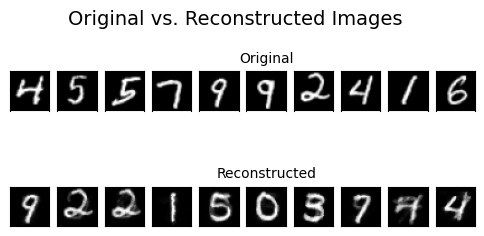

Step: 3000
Loss: 0.006186802871525288


In [8]:
# Lists to store steps and loss values for plotting
steps = []
losses = []

# Train on only a subset of the data distribution
xb, yb = next(train_iterator)
xb = xb.to(device)
yb = yb.to(device)

# Training loop
step = 0
while step < 3001:
    z = torch.randn(xb.size(0), nz, 1, 1, device=device)
    c = torch.nn.functional.one_hot(yb, num_classes=condition_dim).float().to(device)

    s = decoder(z, c)

    loss = ot_loss(s, xb) / torch.numel(xb[0])

    opt.zero_grad()
    loss.backward()
    opt.step()

    step += 1
    steps.append(step)
    losses.append(loss.item())

    if step % 100 == 0:
        plot_images(xb, s)
        print(f"Step: {step}")
        print(f"Loss: {loss.item()}")
        clear_output(wait=True)
    sleep(0.1)

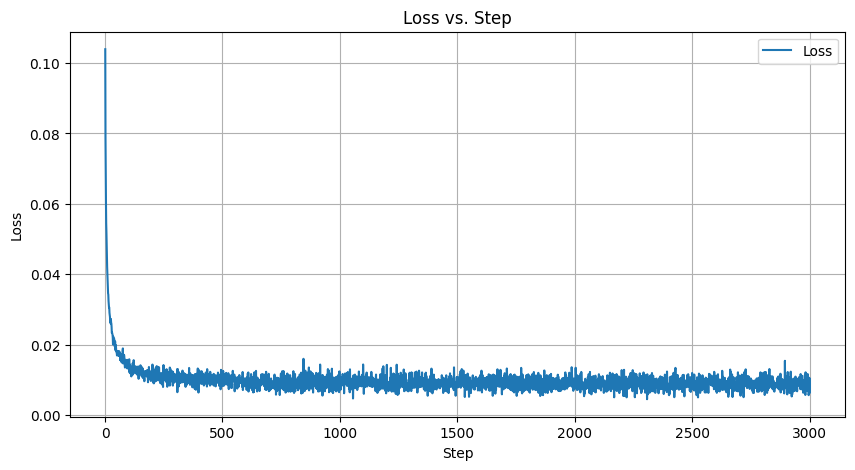

In [9]:
# Plot loss vs. steps
plt.figure(figsize=(10, 5))
plt.plot(steps, losses, label='Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. Step')
plt.legend()
plt.grid(True)
plt.show()